# MUSA 6500 Homework 3: Supervised Land Use Classification with Google Earth Engine

In this assignment, you will use Google Earth Engine via Python to implement multi-class land cover classification. You will hand-label Landsat 8 satellite images which you will then use to train a random forest model. Along the way, you will consider practical remote sensing issues like cloud cover, class imbalances, and feature selection.

**Given that hand-labeling data can be time-consuming, you are encouraged to work in pairs or groups of three to share the workload. You may collaborate on generating the hand-labeled data, provided you submit separate assignment files. If you choose to do this, you should all use the same ROI, of course.**

You are responsible for figuring out the code independently and may refer to tutorials, code examples, or use AI support, but **please cite all sources**.

In particular, we encourage you to consult the [official Python Google Earth Engine `geemap` package](https://geemap.org/), the online course [Spatial Thoughts](https://spatialthoughts.com/courses/google-earth-engine/), and the [Google Earth Engine Tutorials book](https://google-earth-engine.com/).

Submit a single Jupyter Notebook containing code, narrative text, visualizations, and answers to each question. Please also upload your classification results as a GeoTIFF and your accuracy assessment as a CSV file. Open a pull request from your fork of this repository to the main repository for submission.

**<u>Remark:</u>** I work with Riya Saini on this assignment.

## 1. Setup

For this assignment, you will define the region of interest (ROI) of your choice. We recommend picking an urban area large enough that you will have a sufficient sample size but not so large that it will take an excessively long time to process.

You'll also use Landsat 8 satellite imagery from USGS for this assignment. Choose images from 2023, filtering for images with minimal cloud cover.

In [1]:
# Load all necessary libraries
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd

# The following are colab-specific
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
ee.Authenticate()
ee.Initialize(project = "musa-6500-spring-2025")

In [3]:
# Region of Interest: Seattle
seattle_bbox = ee.Geometry.Rectangle([-122.435, 47.495, -122.225, 47.735])

# Define a small buffer to ensure we do not miss Seattle
seattle_buffered = seattle_bbox.buffer(2000)

# Apply scaling factors (Obtained from https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=zh-tw#colab-python)
def apply_scale_factors(image):
  opticalBands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
  return image.addBands(opticalBands, None, True)

# Loading Landsat 8 Collection
seattle_landsat = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
           .filterDate("2023-01-01", "2023-12-31")                        # Filter for 2023
           .filterBounds(seattle_bbox)                                    # Filter for Seattle
           .map(apply_scale_factors)                                      # Apply scaling factors
           .sort("CLOUD_COVER")                                           # Sort by cloud cover percentage in ascending order
           .first()                                                       # Select the least cloudy image
           .clip(seattle_bbox))                                           # Clip the image to Seattle

seattle_landsat_export = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
           .filterDate("2023-01-01", "2023-12-31")                        # Filter for 2023
           .filterBounds(seattle_bbox)                                    # Filter for Seattle
           .map(apply_scale_factors)                                      # Apply scaling factors
           .sort("CLOUD_COVER")                                           # Sort by cloud cover percentage in ascending order
           .first()                                                       # Select the least cloudy image
           .clip(seattle_buffered))                                       # Clip the image to the buffered Seattle zone

In [4]:
# Check the date which the landsat image is pulled from
print("The retrieved image was taken on:", ee.Date(seattle_landsat.get("system:time_start")).format("YYYY-MM-dd").getInfo())
print("The retrieved image was taken on:", ee.Date(seattle_landsat_export.get("system:time_start")).format("YYYY-MM-dd").getInfo())

The retrieved image was taken on: 2023-08-16
The retrieved image was taken on: 2023-08-16


**<u>Remark:</u>** The image that is used for labeling is actually from April 10, 2023 ("2023-04-10"), but somehow when I re-run the codes it gives me an image from August instead.

In [ ]:
# Export the image
geemap.ee_export_image(seattle_landsat_export, scale = 60,
                       filename = "/content/drive/MyDrive/landsat_seattle_2023_v3.tif",
                       region = seattle_buffered)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/landsat_seattle_2023_v3.tif


In [5]:
# Visualization Settings for Seattle image (Obtained from https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=zh-tw#colab-python)
visualization = {
  "bands": ["SR_B4", "SR_B3", "SR_B2"],  # True color (red, green, blue)
  "min": 0.0,
  "max": 0.3
}

In [6]:
# Create Map for visualization (Obtained from https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=zh-tw#colab-python)
Map = geemap.Map()
Map.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

## 2. Data Collection and Feature Engineering

### 2.1 Collecting and Labeling Training Data

Using the [interactive `geemap` intereface](https://www.youtube.com/watch?v=VWh5PxXPZw0) or another approach (e.g., QGIS, ArcGIS, a GeoJSON file, etc.), create at least 100 samples (points or polygons) for each of the following four classes: urban, bare, water, and vegetation. (Again, we encourage you to work in pairs or groups of three to generate these hand labels.) Use visual cues and manual inspection to ensure that the samples are accurate. Assign each class a unique label (e.g., 0 for urban, 1 for bare, 2 for water, and 3 for vegetation) and merge the labeled samples into a single dataset. You are free to propose any labels you like, as long as 1) you include at least 4 classes, and 2) you justify why they are appropriate for a remote sensing task (for example, including a label for ice cream shops wouldn't make sense, because those can't be detected from aerial imagery).

In [ ]:
# The following codes are used to convert the type of "id" into a string so that subsequent geemap-related functions will execute without issues
import json

# Load the GeoJSON file
with open("/content/drive/MyDrive/labels_0743.geojson", "r") as f:
    geojson_data = json.load(f)

# Convert "id" to a string for all features
for feature in geojson_data["features"]:
    feature["id"] = str(feature["id"])  # Convert 'id' to string

# Save the modified GeoJSON back
with open("/content/drive/MyDrive/labels_0743_updated.geojson", "w") as f:
    json.dump(geojson_data, f)

print("GeoJSON has been updated with string IDs!")

In [7]:
labels = geemap.geojson_to_ee("/content/drive/MyDrive/labels_0743_updated.geojson")

In [ ]:
labels.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-122.41904166799998, 47.67268282100008]},
 'id': '1',
 'properties': {'OBJECTID': 1, 'OBJECTID_1': 52, 'Typology': 'W'}}

### 2.2 Feature Engineering.

For possible use in the model, calculate and add the following spectral indices:

- **NDVI** (Normalized Difference Vegetation Index)
- **NDBI** (Normalized Difference Built-up Index)
- **MNDWI** (Modified Normalized Difference Water Index)

Additionally, add elevation and slope data from a DEM. Normalize all image bands to a 0 to 1 scale for consistent model input.

For bonus points, consider adding [kernel filters](https://google-earth-engine.com/Advanced-Image-Processing/Neighborhood-based-Image-Transformation/) (e.g., edge detection, smoothing) to see if they improve model performance.

In [8]:
# Split the data into separate collections based on the "Typology" property
urban = labels.filter(ee.Filter.eq("Typology", "U"))
bare = labels.filter(ee.Filter.eq("Typology", "B"))
water = labels.filter(ee.Filter.eq("Typology", "W"))
vegetation = labels.filter(ee.Filter.eq("Typology", "V"))

# Merge all labeled samples into a single dataset
sample = urban.merge(bare).merge(water).merge(vegetation)

# Define a dictionary mapping "Typology" to numeric labels
label_map = ee.Dictionary({
    "U": 0, # Urban
    "B": 1, # Bare
    "W": 2, # Water
    "V": 3  # Vegetation
})

# Function to assign numeric labels based on "Typology"
def label_to_numeric(feature):
    return feature.set("Landcover", label_map.get(feature.get("Typology")))

# Apply the function to the training data
sample = sample.map(label_to_numeric)

# Check the property names of the first feature to ensure 'landcover' was added
print(sample.first().propertyNames().getInfo())

['Landcover', 'system:index', 'OBJECTID', 'OBJECTID_1', 'Typology']


In [9]:
# NDVI (Normalized Difference Vegetation Index)
ndvi = seattle_landsat_export.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")

# NDBI (Normalized Difference Built-up Index)
ndbi = seattle_landsat_export.normalizedDifference(["SR_B6", "SR_B5"]).rename("NDBI")

# MNDWI (Modified Normalized Difference Water Index)
mndwi = seattle_landsat_export.normalizedDifference(["SR_B3", "SR_B7"]).rename("MNDWI")

# Add indices to the image
seattle_landsat_export = seattle_landsat_export.addBands([ndvi, ndbi, mndwi])

In [10]:
# Load SRTM DEM
dem = ee.Image("USGS/SRTMGL1_003").clip(seattle_buffered)
slope = ee.Terrain.slope(dem)

# Add elevation and slope bands to the image
seattle_landsat_export = seattle_landsat_export.addBands(dem.rename("Elevation"))
seattle_landsat_export = seattle_landsat_export.addBands(slope.rename("Slope"))

In [11]:
def normalize(image, band):
    min_max = image.reduceRegion(ee.Reducer.minMax(), seattle_buffered, 30, bestEffort = True)
    min_val = ee.Number(min_max.get(f"{band}_min"))
    max_val = ee.Number(min_max.get(f"{band}_max"))
    normalized = image.select(band).subtract(min_val).divide(max_val.subtract(min_val)).rename(f"{band}_norm")
    return normalized.updateMask(normalized.gt(0).And(normalized.lte(1)))  # Mask out invalid values

bands_to_normalize = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "NDVI", "NDBI", "MNDWI", "Elevation", "Slope"]
normalized_bands = [normalize(seattle_landsat_export, band) for band in bands_to_normalize]

# Combine all features
final_image = ee.Image.cat(normalized_bands)

In [12]:
# Sobel filter (Edge Detection)
sobel_kernel = ee.Kernel.sobel()
sobel_image = final_image.convolve(sobel_kernel).rename(
    final_image.bandNames().map(lambda name: ee.String(name).cat("_sobel"))
)

# Gaussian smoothing filter
gaussian_kernel = ee.Kernel.gaussian(radius = 3, sigma = 1.0, units = "pixels")
smooth_image = final_image.convolve(gaussian_kernel).rename(
    final_image.bandNames().map(lambda name: ee.String(name).cat("_smooth"))
)

# Combine original normalized bands with filtered bands
final_image_with_filters = final_image.addBands(sobel_image).addBands(smooth_image)

In [13]:
Map2 = geemap.Map()
Map2.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map2.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map2.addLayer(final_image_with_filters.select("SR_B4_norm"), {"min": 0, "max": 1}, "Normalized Red Band")
Map2.addLayer(final_image_with_filters.select("NDVI_norm"), {"min": 0, "max": 1}, "Normalized NDVI")
Map2.addLayer(final_image_with_filters.select("Elevation_norm"), {"min": 0, "max": 1}, "Normalized Elevation")
Map2.addLayer(final_image_with_filters.select("SR_B4_norm_sobel"), {"min": -1, "max": 1}, "Red Band Edge")
Map2.addLayer(final_image_with_filters.select("SR_B4_norm_smooth"), {"min": -1, "max": 1}, "Red Band Smooth")

Map2  # Display the map

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

In [14]:
# Combine NDVI, NDBI, MNDWI, Slope, and elevation to samples
sample = final_image_with_filters.sampleRegions(
    collection = sample,
    properties = ["Landcover"],
    scale = 30,
    geometries = True
)

# Check that features were added
sample.first().getInfo()

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Point',
  'coordinates': [-122.38284136180354, 47.636099752488455]},
 'id': '1_1_1_152_0',
 'properties': {'Elevation_norm': 0.17224881052970886,
  'Elevation_norm_smooth': 0.1698793946705717,
  'Elevation_norm_sobel': -0.0382775217294693,
  'Landcover': 0,
  'MNDWI_norm': 0.670789207520759,
  'MNDWI_norm_smooth': 0.6322656177288455,
  'MNDWI_norm_sobel': 0.01567920787443089,
  'NDBI_norm': 0.45903316577719816,
  'NDBI_norm_smooth': 0.46955481773286356,
  'NDBI_norm_sobel': -0.04114848566964491,
  'NDVI_norm': 0.5162980536111927,
  'NDVI_norm_smooth': 0.5176537542522495,
  'NDVI_norm_sobel': 0.03277581587798606,
  'SR_B1_norm': 0.7582563625490066,
  'SR_B1_norm_smooth': 0.62933798746589,
  'SR_B1_norm_sobel': 0.41434646820386734,
  'SR_B2_norm': 0.764887225140772,
  'SR_B2_norm_smooth': 0.6290026360277852,
  'SR_B2_norm_sobel': 0.4522004466953974,
  'SR_B3_norm': 0.7543748752412004,
  'SR_B3_norm_smooth': 0.597278402445321

## 3. Model Training and Evaluation

### 3.1 Model Training

Split your data into a training dataset (70%) and a validation dataset (30%). Train and evaluate a random forest model using the training set with all engineered features.

After training, analyze [variable importance scores](https://stackoverflow.com/questions/74519767/interpreting-variable-importance-from-random-forest-in-gee) to justify each feature's inclusion. Identify which features are most influential in the classification. Report the final features that you keep in your model.

In [15]:
# Train-test split (70/30)
seed_value = 42

# Split
sample = sample.randomColumn("split", seed_value)
sample_train = sample.filter(ee.Filter.lt("split", 0.7))
sample_test = sample.filter(ee.Filter.gte("split", 0.7))

Model 1: Using normalized bands, NDVI, NDBI, MNDWI, elevation, and slope as features.

In [16]:
features = [
    "SR_B1_norm", "SR_B2_norm", "SR_B3_norm", "SR_B4_norm", "SR_B5_norm",
    "SR_B6_norm", "SR_B7_norm", "NDVI_norm", "NDBI_norm", "MNDWI_norm",
    "Elevation_norm", "Slope_norm"
]

# Random forest model 1
model1 = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features
)

# Variable importance scores
importance_model1 = model1.explain().get("importance")
importance_scores_model1 = importance_model1.getInfo()

importance_model1_df = pd.DataFrame(list(importance_scores_model1.items()),
                                    columns = ["Feature", "Importance Score"])
importance_model1_df = importance_model1_df.sort_values(by = "Importance Score",
                                                        ascending = False)
importance_model1_df

,Feature,Importance Score
3,NDVI_norm,30.541194
4,SR_B1_norm,27.077881
1,MNDWI_norm,26.289092
6,SR_B3_norm,25.778203
7,SR_B4_norm,24.963027
10,SR_B7_norm,23.423418
2,NDBI_norm,23.049553
5,SR_B2_norm,21.662831
9,SR_B6_norm,21.098664
0,Elevation_norm,20.444236


Based on the variable importance scores, I decided to drop all features with an importance score below 23, i.e., I am retaining "NDVI_norm", "SR_B1_norm", "MNDWI_norm", "SR_B3_norm", "SR_B4_norm", "SR_B7_norm", and "NDBI_norm" as features.
Roughly speaking, the selected features capture diverse aspects of landcover classification:

*   Vegetation ("NDVI_norm", "SR_B3_norm", "SR_B4_norm")
*   Water ("MNDWI_norm", "SR_B1_norm")
*   Urban/Built-up areas ("NDBI_norm", "SR_B7_norm")

In [17]:
# Refined model 1
features_refined = [
    "NDVI_norm", "SR_B1_norm", "MNDWI_norm", "SR_B3_norm", "SR_B4_norm",
    "SR_B7_norm", "NDBI_norm"
]

# Random forest model 1
model1_refined = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_refined
)

# Variable importance scores
importance_model1_refined = model1_refined.explain().get("importance")
importance_scores_model1_refined = importance_model1_refined.getInfo()

importance_model1_refined_df = pd.DataFrame(list(importance_scores_model1_refined.items()),
                                            columns = ["Feature", "Importance Score"])
importance_model1_refined_df = importance_model1_refined_df.sort_values(by = "Importance Score",
                                                                        ascending = False)
importance_model1_refined_df

,Feature,Importance Score
2,NDVI_norm,52.916254
0,MNDWI_norm,49.965854
4,SR_B3_norm,47.709616
1,NDBI_norm,45.369480
5,SR_B4_norm,43.656295
3,SR_B1_norm,43.149591
6,SR_B7_norm,37.388739


Model 2: Using normalized and smoothed bands, NDVI, NDBI, MNDWI, elevation, and slope as features.

In [18]:
features_m2 = [
    "SR_B1_norm_smooth", "SR_B2_norm_smooth", "SR_B3_norm_smooth",
    "SR_B4_norm_smooth", "SR_B5_norm_smooth", "SR_B6_norm_smooth",
    "SR_B7_norm_smooth", "NDVI_norm_smooth", "NDBI_norm_smooth",
    "MNDWI_norm_smooth", "Elevation_norm_smooth", "Slope_norm_smooth"
]

# Random forest model 2
model2 = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m2
)

# Variable importance scores
importance_model2 = model2.explain().get("importance")
importance_scores_model2 = importance_model2.getInfo()

importance_model2_df = pd.DataFrame(list(importance_scores_model2.items()),
                                    columns = ["Feature", "Importance Score"])
importance_model2_df = importance_model2_df.sort_values(by = "Importance Score",
                                                        ascending = False)
importance_model2_df

,Feature,Importance Score
4,SR_B1_norm_smooth,23.795708
1,MNDWI_norm_smooth,23.777712
10,SR_B7_norm_smooth,22.556238
6,SR_B3_norm_smooth,21.531813
3,NDVI_norm_smooth,20.236536
2,NDBI_norm_smooth,20.116521
5,SR_B2_norm_smooth,19.962764
7,SR_B4_norm_smooth,19.920819
0,Elevation_norm_smooth,18.656483
8,SR_B5_norm_smooth,17.190923


Based on the variable importance scores, I decided to drop all features with an importance score below 20, i.e., I am retaining "SR_B1_norm_smooth", "MNDWI_norm_smooth", "SR_B7_norm_smooth", "SR_B3_norm_smooth", "NDVI_norm_smooth", and "NDBI_norm_smooth" as features.
Roughly speaking, the selected features capture diverse aspects of landcover classification:

*   Vegetation ("NDVI_norm_smooth", "SR_B3_norm_smooth")
*   Water ("MNDWI_norm_smooth", "SR_B1_norm_smooth")
*   Urban/Built-up areas ("NDBI_norm_smooth", "SR_B7_norm_smooth")

In [19]:
# Refined model 2
features_m2_refined = [
    "SR_B1_norm_smooth", "MNDWI_norm_smooth", "SR_B7_norm_smooth",
    "SR_B3_norm_smooth", "NDVI_norm_smooth", "NDBI_norm_smooth"
]

# Random forest model 2
model2_refined = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m2_refined
)

# Variable importance scores
importance_model2_refined = model2_refined.explain().get("importance")
importance_scores_model2_refined = importance_model2_refined.getInfo()

importance_model2_refined_df = pd.DataFrame(list(importance_scores_model2_refined.items()),
                                            columns = ["Feature", "Importance Score"])
importance_model2_refined_df = importance_model2_refined_df.sort_values(by = "Importance Score",
                                                                        ascending = False)
importance_model2_refined_df

,Feature,Importance Score
0,MNDWI_norm_smooth,46.387211
3,SR_B1_norm_smooth,44.868181
4,SR_B3_norm_smooth,40.680898
1,NDBI_norm_smooth,39.119938
5,SR_B7_norm_smooth,35.083787
2,NDVI_norm_smooth,34.490383


Model 3: Using normalized bands, NDVI, NDBI, MNDWI, elevation, and slope with edge detection (using the Sobel kernel) as features.

In [20]:
features_m3 = [
    "SR_B1_norm_sobel", "SR_B2_norm_sobel", "SR_B3_norm_sobel",
    "SR_B4_norm_sobel", "SR_B5_norm_sobel", "SR_B6_norm_sobel",
    "SR_B7_norm_sobel", "NDVI_norm_sobel", "NDBI_norm_sobel",
    "MNDWI_norm_sobel", "Elevation_norm_sobel", "Slope_norm_sobel"
]

# Random forest model 3
model3 = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m3
)

# Variable importance scores
importance_model3 = model3.explain().get("importance")
importance_scores_model3 = importance_model3.getInfo()

importance_model3_df = pd.DataFrame(list(importance_scores_model3.items()),
                                    columns = ["Feature", "Importance Score"])
importance_model3_df = importance_model3_df.sort_values(by = "Importance Score",
                                                        ascending = False)
importance_model3_df

,Feature,Importance Score
4,SR_B1_norm_sobel,66.506976
3,NDVI_norm_sobel,66.225873
2,NDBI_norm_sobel,60.946285
0,Elevation_norm_sobel,59.103016
11,Slope_norm_sobel,58.895630
5,SR_B2_norm_sobel,57.682689
1,MNDWI_norm_sobel,57.382463
7,SR_B4_norm_sobel,56.561037
8,SR_B5_norm_sobel,56.350918
10,SR_B7_norm_sobel,53.757174


Based on the variable importance scores, I decided to drop all features with an importance score below 57, i.e., I am retaining "SR_B1_norm_sobel", "NDVI_norm_sobel", "NDBI_norm_sobel", "Elevation_norm_sobel", "Slope_norm_sobel", "SR_B2_norm_sobel", and "MNDWI_norm_sobel" as features.
Roughly speaking, the selected features capture diverse aspects of landcover classification:

*   Vegetation ("NDVI_norm_sobel")
*   Water ("MNDWI_norm_sobel", "SR_B1_norm_sobel")
*   Urban/Built-up areas ("NDBI_norm_sobel", "SR_B2_norm_sobel", "Elevation_norm_sobel", "Slope_norm_sobel")

In [21]:
# Refined model 3
features_m3_refined = [
    "SR_B1_norm_sobel", "NDVI_norm_sobel", "NDBI_norm_sobel",
    "Elevation_norm_sobel", "Slope_norm_sobel", "SR_B2_norm_sobel",
    "MNDWI_norm_sobel"
]

# Random forest model 3
model3_refined = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m3_refined
)

# Variable importance scores
importance_model3_refined = model3_refined.explain().get("importance")
importance_scores_model3_refined = importance_model3_refined.getInfo()

importance_model3_refined_df = pd.DataFrame(list(importance_scores_model3_refined.items()),
                                            columns = ["Feature", "Importance Score"])
importance_model3_refined_df = importance_model3_refined_df.sort_values(by = "Importance Score",
                                                                        ascending = False)
importance_model3_refined_df

,Feature,Importance Score
3,NDVI_norm_sobel,124.637851
4,SR_B1_norm_sobel,114.761303
5,SR_B2_norm_sobel,110.289893
2,NDBI_norm_sobel,110.009586
0,Elevation_norm_sobel,104.518664
6,Slope_norm_sobel,97.033547
1,MNDWI_norm_sobel,88.111649


### 3.2 Accuracy Assessment

Use the trained model to classify the Landsat 8 image, creating a land cover classification map with classes for urban, bare, water, and vegetation (or whatever classes you have chosen).

Using the validation data, generate a confusion matrix and calculate the overall accuracy, precision, and recall. Which classes were confused most often with each other? Why do you think this was?

Visually compare your landcover data for your ROI with the corresponding [landcover data from the European Space Agency](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200). Do your classifications agree? If not, do you notice any patterns in the types of landcover where they differ, or any particular features in the imagery that are hard for your model to recognize (e.g., sand, water, or asphalt)?

Export the classified image as a GeoTIFF and the confusion matrix and accuracy metrics to a CSV file for documentation.

In [22]:
# Apply the refined model 1 to Landsat 8 image
classified_m1 = final_image_with_filters.classify(model1_refined)

# We use grey for "Urban", brown for "Bare", blue for "Water", and green for "Vegetation"
Map3 = geemap.Map()
Map3.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map3.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map3.addLayer(classified_m1, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Classification - Model 1")
Map3

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

In [23]:
# Apply the refined model 2 to Landsat 8 image
classified_m2 = final_image_with_filters.classify(model2_refined)

# We use grey for "Urban", brown for "Bare", blue for "Water", and green for "Vegetation"
Map4 = geemap.Map()
Map4.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map4.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map4.addLayer(classified_m2, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Classification - Model 2")
Map4

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
# Apply the refined model 3 to Landsat 8 image
classified_m3 = final_image_with_filters.classify(model3_refined)

# We use grey for "Urban", brown for "Bare", blue for "Water", and green for "Vegetation"
Map5 = geemap.Map()
Map5.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map5.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map5.addLayer(classified_m3, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Classification - Model 3")
Map5

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

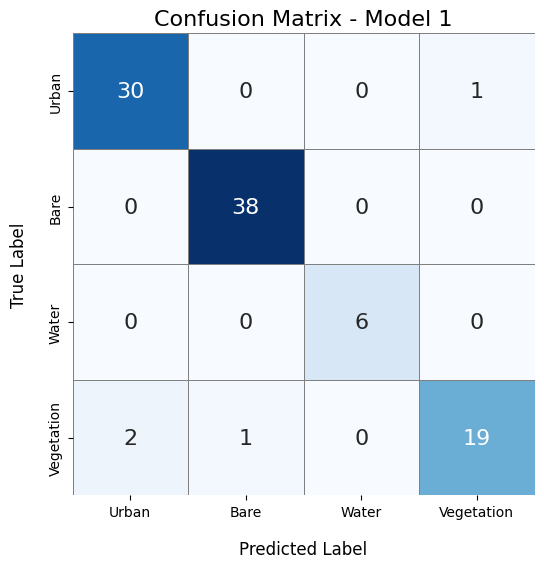

Overall Accuracy: 0.9588


,Class,Precision,Recall
0,Urban,0.9677,0.9375
1,Bare,1.0000,0.9744
2,Water,1.0000,1.0000
3,Vegetation,0.8636,0.9500


In [25]:
# Evaluation metrics for the refined model 1
classified_testing_m1 = sample_test.classify(model1_refined)
conf_matrix_m1 = classified_testing_m1.errorMatrix("Landcover", "classification")

labels = ["Urban", "Bare", "Water", "Vegetation"]
conf_matrix_m1_df = pd.DataFrame(conf_matrix_m1.getInfo(), index = labels, columns = labels)

# Plot the heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_m1_df, annot = True, fmt = "d", cmap = "Blues",
            cbar = False, annot_kws = {"size": 16}, linewidths = 0.5,
            linecolor = "gray", square = True)
plt.title("Confusion Matrix - Model 1", fontsize = 16)
plt.ylabel("True Label", fontsize = 12, labelpad = 15)
plt.xlabel("Predicted Label", fontsize = 12, labelpad = 15)
plt.show()

overall_acc_m1 = conf_matrix_m1.accuracy()
precision_m1 = conf_matrix_m1.producersAccuracy()
recall_m1 = conf_matrix_m1.consumersAccuracy()

precision_values_m1 = precision_m1.getInfo()
recall_values_m1 = recall_m1.getInfo()

df_results_m1 = pd.DataFrame({
    "Class": labels,
    "Precision": [round(precision[0], 4) for precision in precision_values_m1],
    "Recall": [round(recall, 4) for recall in recall_values_m1[0]]
})

print("Overall Accuracy:", round(overall_acc_m1.getInfo(), 4))

df_results_m1

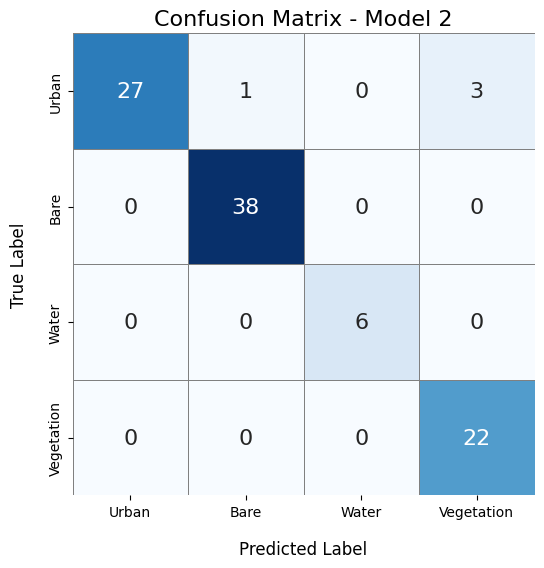

Overall Accuracy: 0.9588


,Class,Precision,Recall
0,Urban,0.871,1.0000
1,Bare,1.000,0.9744
2,Water,1.000,1.0000
3,Vegetation,1.000,0.8800


In [26]:
# Evaluation metrics for the refined model 2
classified_testing_m2 = sample_test.classify(model2_refined)
conf_matrix_m2 = classified_testing_m2.errorMatrix("Landcover", "classification")

conf_matrix_m2_df = pd.DataFrame(conf_matrix_m2.getInfo(), index = labels, columns = labels)

# Plot the heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_m2_df, annot = True, fmt = "d", cmap = "Blues",
            cbar = False, annot_kws = {"size": 16}, linewidths = 0.5,
            linecolor = "gray", square = True)
plt.title("Confusion Matrix - Model 2", fontsize = 16)
plt.ylabel("True Label", fontsize = 12, labelpad=15)
plt.xlabel("Predicted Label", fontsize = 12, labelpad=15)
plt.show()

overall_acc_m2 = conf_matrix_m2.accuracy()
precision_m2 = conf_matrix_m2.producersAccuracy()
recall_m2 = conf_matrix_m2.consumersAccuracy()

precision_values_m2 = precision_m2.getInfo()
recall_values_m2 = recall_m2.getInfo()

df_results_m2 = pd.DataFrame({
    "Class": labels,
    "Precision": [round(precision[0], 4) for precision in precision_values_m2],
    "Recall": [round(recall, 4) for recall in recall_values_m2[0]]
})

print("Overall Accuracy:", round(overall_acc_m2.getInfo(), 4))

df_results_m2

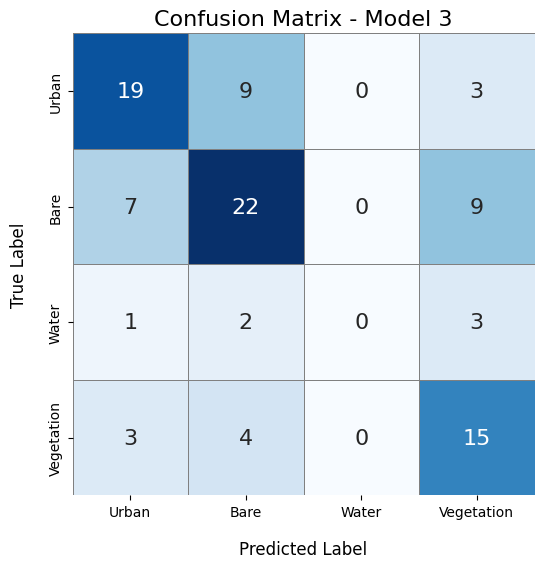

Overall Accuracy: 0.5773


,Class,Precision,Recall
0,Urban,0.6129,0.6333
1,Bare,0.5789,0.5946
2,Water,0.0000,0.0000
3,Vegetation,0.6818,0.5000


In [27]:
# Evaluation metrics for the refined model 3
classified_testing_m3 = sample_test.classify(model3_refined)
conf_matrix_m3 = classified_testing_m3.errorMatrix("Landcover", "classification")

conf_matrix_m3_df = pd.DataFrame(conf_matrix_m3.getInfo(), index = labels, columns = labels)

# Plot the heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_m3_df, annot = True, fmt = "d", cmap = "Blues",
            cbar = False, annot_kws = {"size": 16}, linewidths = 0.5,
            linecolor = "gray", square = True)
plt.title("Confusion Matrix - Model 3", fontsize = 16)
plt.ylabel("True Label", fontsize = 12, labelpad=15)
plt.xlabel("Predicted Label", fontsize = 12, labelpad=15)
plt.show()

overall_acc_m3 = conf_matrix_m3.accuracy()
precision_m3 = conf_matrix_m3.producersAccuracy()
recall_m3 = conf_matrix_m3.consumersAccuracy()

precision_values_m3 = precision_m3.getInfo()
recall_values_m3 = recall_m3.getInfo()

df_results_m3 = pd.DataFrame({
    "Class": labels,
    "Precision": [round(precision[0], 4) for precision in precision_values_m3],
    "Recall": [round(recall, 4) for recall in recall_values_m3[0]]
})

print("Overall Accuracy:", round(overall_acc_m3.getInfo(), 4))

df_results_m3

Using validation data, models 1 and 2 achieve the same overall accuracy of 95.88%, while model 3, with an overall accuracy of 57.73%, performs substantially worse.

In model 1, "vegetation" is confused twice as "urban" and once as "bare", while "urban" is confused once as "vegetation".

- It could be the case that vegetation near urban areas, for instance, parks or green spaces, share similar spectral properties with urban vegetations.
This could lead to mis-classifications between them.
- Sparse vegetation or dry grasslands may share similar spectral features with bare soil, leading to mis-classifications between "bare" and "vegetation".
- There could be urban areas with significant vegetations in the city, in which there could be substantial overlap between the spectral features of "urban" and "vegetation", leading to mis-classifications.

On the other hand, in model 2, "urban" is confused three times as "vegetation" and once as "bare".

- In this model, all the features are first normalized, then smoothed via a Gaussian filter.
The smoothing reduces sharp edges or transitions, so that when there are urban areas adjacent to vegetations or bare soils, the model may mis-classify them.

Model 3 fails to classify any water bodies, as indicated by the 0 precision and recall.
It does not perform much better with other classes as well, with "urban" and "bare" being confused many times as suggested by the deep blue colors on the top left 2-by-2 confusion matrix above.

- Sobel filtering emphasizes edges and gradients.
In turn, it will lose information on homogeneous regions, such as large water bodies or dense vegetations.
- Model 3 includes elevation and slope as predictors, which provide little information on flat surfaces.

In [28]:
# Landcover data from the European Space Agency, palette based on their product user manual
esa_params = {
    "bands": ["Map"],  #
    "min": 10,
    "max": 100,
    "palette": [
        "#006400",  # Tree Cover
        "#ffbb22",  # Shrubland
        "#ffff4c",  # Grassland
        "#f096ff",  # Cropland
        "#fa0000",  # Built-up Area
        "#b4b4b4",  # Bare & Sparse Vegetation
        "#f0f0f0",  # Snow & Ice
        "#0064c8",  # Permanent Water Bodies
        "#0096a0",  # Herbaceous Wetland
        "#00cf75",  # Mangroves
        "#fae6a0"   # Moss & Lichen
    ]
}
esa_seattle = ee.ImageCollection("ESA/WorldCover/v200").first().clip(seattle_buffered)

In [29]:
# Visual comparison - Models 1, 2, 3
Map6 = geemap.Map()
Map6.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map6.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map6.addLayer(classified_m1, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Classification - Model 1")
Map6.addLayer(classified_m2, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Classification - Model 2")
Map6.addLayer(classified_m3, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Classification - Model 3")
Map6.addLayer(esa_seattle, esa_params, "ESA WorldCover - Seattle")
Map6

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

The classifications based on model 3 differ the most with the ESA landcover data.
But this is expected, since model 3 has the worst performance.
The classifications from models 1 and 2, on the other hand, align more closely with the ESA landcover data.
A brief inspection suggests that the additional smoothing performed on the features included in model 2 may sometimes classify larger areas as, for instance, vegetation or tree covers.
Personally, I would say model 1 captures the contours slightly better.

In [ ]:
export_task_m1 = ee.batch.Export.image.toDrive(
    image = classified_m1,
    description = "Classified_Landcover_Model_1",
    folder = "MUSA6500",                          # Folder in Google Drive
    region = seattle_landsat_export.geometry(),   # Region of interest
    scale = 30,                                   # Resolution in meters (e.g., Landsat resolution)
    maxPixels = 1e13,                             # Maximum allowed pixels
    fileFormat = "GeoTIFF"
)

export_task_m1.start()

In [ ]:
export_task_m2 = ee.batch.Export.image.toDrive(
    image = classified_m2,
    description = "Classified_Landcover_Model_2",
    folder = "MUSA6500",                          # Folder in Google Drive
    region = seattle_landsat_export.geometry(),   # Region of interest
    scale = 30,                                   # Resolution in meters (e.g., Landsat resolution)
    maxPixels = 1e13,                             # Maximum allowed pixels
    fileFormat = "GeoTIFF"
)

export_task_m2.start()

In [ ]:
export_task_m3 = ee.batch.Export.image.toDrive(
    image = classified_m3,
    description = "Classified_Landcover_Model_3",
    folder = "MUSA6500",                          # Folder in Google Drive
    region = seattle_landsat_export.geometry(),   # Region of interest
    scale = 30,                                   # Resolution in meters (e.g., Landsat resolution)
    maxPixels = 1e13,                             # Maximum allowed pixels
    fileFormat = "GeoTIFF"
)

export_task_m3.start()

In [ ]:
# Save confusion matrix as CSV
conf_matrix_m1_df.to_csv("/content/drive/MyDrive/MUSA6500/Confusion_Matrix_Model_1.csv", index = True)
conf_matrix_m2_df.to_csv("/content/drive/MyDrive/MUSA6500/Confusion_Matrix_Model_2.csv", index = True)
conf_matrix_m3_df.to_csv("/content/drive/MyDrive/MUSA6500/Confusion_Matrix_Model_3.csv", index = True)

In [ ]:
metrics_m1_df = pd.DataFrame({
    "Metric": ["Overall Accuracy"] + ["Precision - " + cls for cls in df_results_m1["Class"]] + ["Recall - " + cls for cls in df_results_m1["Class"]],
    "Value": [round(overall_acc_m1.getInfo(), 4)] + list(df_results_m1["Precision"]) + list(df_results_m1["Recall"])
})

metrics_m2_df = pd.DataFrame({
    "Metric": ["Overall Accuracy"] + ["Precision - " + cls for cls in df_results_m2["Class"]] + ["Recall - " + cls for cls in df_results_m2["Class"]],
    "Value": [round(overall_acc_m2.getInfo(), 4)] + list(df_results_m2["Precision"]) + list(df_results_m2["Recall"])
})

metrics_m3_df = pd.DataFrame({
    "Metric": ["Overall Accuracy"] + ["Precision - " + cls for cls in df_results_m3["Class"]] + ["Recall - " + cls for cls in df_results_m3["Class"]],
    "Value": [round(overall_acc_m3.getInfo(), 4)] + list(df_results_m3["Precision"]) + list(df_results_m3["Recall"])
})


# Save accuracy metrics as CSV
metrics_m1_df.to_csv("/content/drive/MyDrive/MUSA6500/Accuracy_Metrics_Model_1.csv", index = False)
metrics_m2_df.to_csv("/content/drive/MyDrive/MUSA6500/Accuracy_Metrics_Model_2.csv", index = False)
metrics_m3_df.to_csv("/content/drive/MyDrive/MUSA6500/Accuracy_Metrics_Model_3.csv", index = False)

The final .csv file is manually produced by combining all the 6 exported .csv files.

## 4. Reflection Questions

What limitations did you run into when completing this assignment? What might you do differently if you repeated it, or what might you change if you had more time and/or resources?

What was the impact of feature engineering? Which layers most contributed to the model? Did you expect this? Why or why not?

Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? If so, how might you resolve this in the future (hint: consider a different sampling technique).

Did your model perform better on one class than another? Why? Can you think of a reason that this might be good or bad depending on the context?

Limitations/Challenges:
- The region of interest (Seattle) may not have enough bare areas, so that the labeling step is more challenging.
Also, perhaps it is my inexperience with satellite imageries and urban planning, but I find distinguishing and labeling bare lands more difficult.
- If I have more time and/or resources, I may search for more potential regions of interest, and take more time to consult with my teammate, so that we can come up with an agreement in terms of labeling.

Impacts of feature engineering:
- It ensures that no feature is going to dominate purely because of their raw values.
- While I selected different features for each model, in general, "SR_B1", "SR_B3", "SR_B7", "NDVI", "MNDWI", and "NDBI" are included.
In general, I expected such observations.
For instance, there are large areas of vegetations and urban areas, so it is not surprising that bands or spectral indices related to them play a significant role.

Data:
- I find it somewhat difficult to create the training data by hand.
My teammate and I use ArcGIS Pro to label the data, and had my teammate not shown me how it is done and created the framework firsthand, I would have a very hard time doing so.
Although, admittedly it was a pretty fun and nice experience!
- I did notice issues with class imbalance.
Specifically, I recalled that in my training and testing data, there are less "water" than the other classes.
This class imbalance may inhibit the model's ability to classify water bodies.
In the future, it would be better if we can split our sample into training and testing data in a stratified way.
I know that the "train_test_split()" from the "scikit-learn" module has a "stratify" parameter, which performs exactly this job.
But, I did not manage to find an equivalent application from the "ee" module.

Model performance:
- In general, I feel like my models performed pretty good across classes.
The occasion mis-classifications, as conjectured above, are probably due to similar spectral features among neighboring pixels/areas.

For this assignment, I have consulted numerous sources, including ChatGPT, Perplexity, the class notebook "nlcd_supervised_classification.ipynb", and sources included in the assignment in the first place.